# Step 6.1 - Model and evaluation

## A. Import thư viện

In [1]:
# 1. Import library
import lib.step1ml_utilis_summaryPre_processing as pre
import lib.step2ml_utils_feature_selection as fea
import lib.step3ml_utils_model_design_testing_regression as reg
import lib.step4ml_utils_model_design_testing_explainability as exp
import lib.step5ml_utils_model_design_testing_visualize_models as vis
import lib.step6ml_utils_model_design_testing_geospatial_analysis as geo
import lib.step9ml_Text_Kmeans_Clustering as clu
import lib.step11ml_utilis_model_design_time_series as ser
import matplotlib
import matplotlib_inline
%matplotlib inline


import warnings
warnings.filterwarnings("ignore")

Importing plotly failed. Interactive plots will not work.


## B. Model

### 1.0. Upload dữ liệu

In [2]:
import pandas as pd
dir_file = "data/avocado_model.csv"
df = pd.read_csv(dir_file)
df.head()

,Unnamed: 0,fea_date,fea_average_price,fea_total_Volume,fea_item_4046,fea_item_4225,fea_item_4770,fea_total_Bags,fea_small_bags,fea_large_bags,...,Item_4046,Item_4225,Item_4770,Total_Bags,Small_Bags,Large_Bags,XLarge_Bags,type,year,region
0,1,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,...,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.00,conventional,2015,Albany
1,2,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,...,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.00,conventional,2015,Albany
2,3,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,...,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.00,conventional,2015,Albany
3,4,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,...,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.00,conventional,2015,Albany
4,5,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,...,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.00,conventional,2015,Albany


### 1.1. Lọc dữ liệu theo bài toán

In [3]:
# Lọc dữ liệu organic
feature_name = 'type'
name_type = 'organic'
data_organic = pre.filter_dataframe(df=df, feature_name=feature_name, name_type=name_type)

close


In [4]:
# Lọc dữ liệu bang California
name_type = 'California'
feature_name = 'region'
data_california = pre.filter_dataframe(df=data_organic, feature_name=feature_name, name_type=name_type)

close


### 1.2. Thực hiện pre-processing dữ liệu

In [5]:
data_california["fea_date"] = pd.to_datetime(data_california['fea_date'], format='%Y-%m-%d')

In [6]:
data_processing = data_california.groupby("fea_date")["fea_total_Volume"].sum().rename("fea_total_Volume")
data_processing.head()

fea_date
2015-01-04   142349.77
2015-01-11   158110.68
2015-01-18   195207.60
2015-01-25   121698.02
2015-02-01   196031.90
Name: fea_total_Volume, dtype: float64

In [7]:
data_processing.head()

fea_date
2015-01-04   142349.77
2015-01-11   158110.68
2015-01-18   195207.60
2015-01-25   121698.02
2015-02-01   196031.90
Name: fea_total_Volume, dtype: float64

In [8]:
data_processing.tail()

fea_date
2018-02-25   179041.72
2018-03-04   239135.67
2018-03-11   236822.98
2018-03-18   202790.74
2018-03-25   190257.38
Name: fea_total_Volume, dtype: float64

#### 1.3. TimeSeries Analysis
#### Check for:
- Trend 
- Level
- Outliers
- Stationarity
- Seasonality (define s)

#### 1.3.1. Target Variable

In [9]:
end = "2022-03-24"

In [10]:
print("population --> len:", len(data_processing), "| mean:", round(data_processing.mean()), " | std:", round(data_processing.std()))
w = 30
print("moving --> len:", w, " | mean:", round(data_processing.ewm(span=w).mean()[-1]), " | std:", round(data_processing.ewm(span=w).std()[-1]))

population --> len: 169 | mean: 150206  | std: 42486
moving --> len: 30  | mean: 170037  | std: 37424


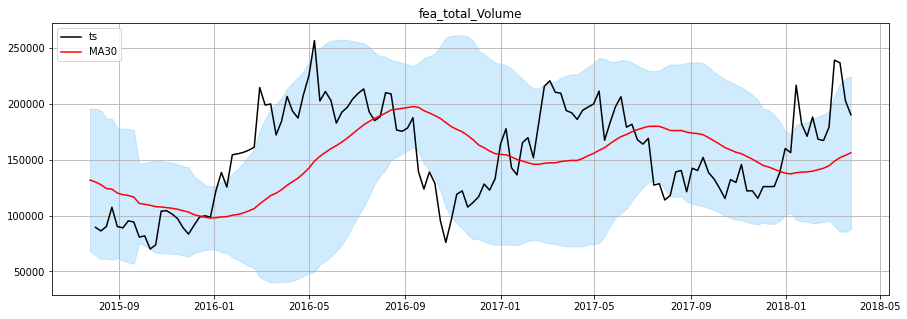

In [11]:
ser.plot_ts(data_processing, plot_ma=True, plot_intervals=True, window=w, figsize=(15,5))

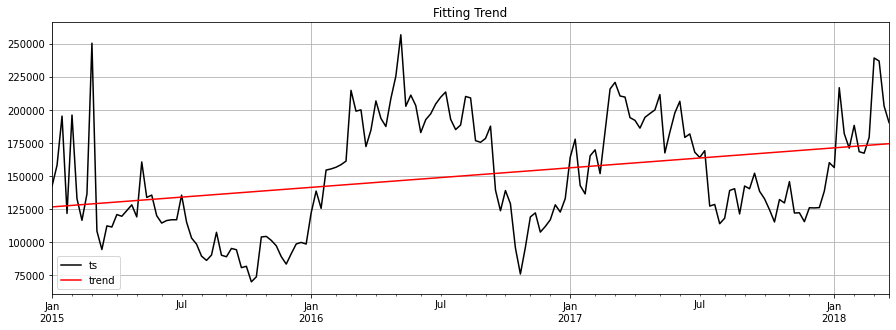

In [12]:
trend, line = ser.fit_trend(data_processing, degree=1, plot=True, figsize=(15,5))

In [13]:
# -> There is a slight trend and it's linear ("additive")
print("constant:", round(line[-1],2), "| slope:", round(line[0],2))

constant: 126339.32 | slope: 284.13


#### 1.3.2. Level

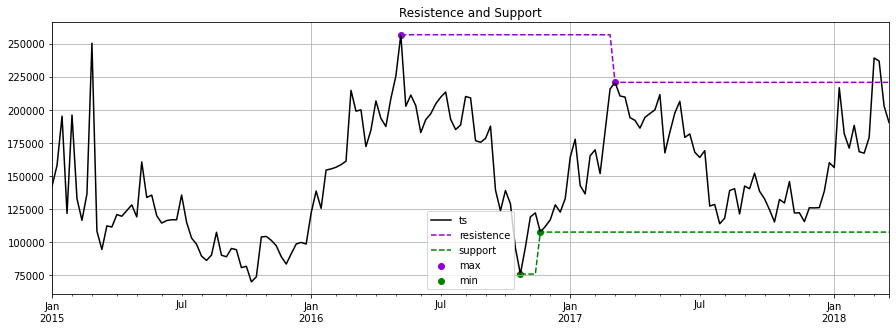

In [14]:
res_sup = ser.resistence_support(data_processing, window=30, trend=False, plot=True, figsize=(15,5))

#### 1.3.3 Outliers


#### 1.3.3.1. Stationarity

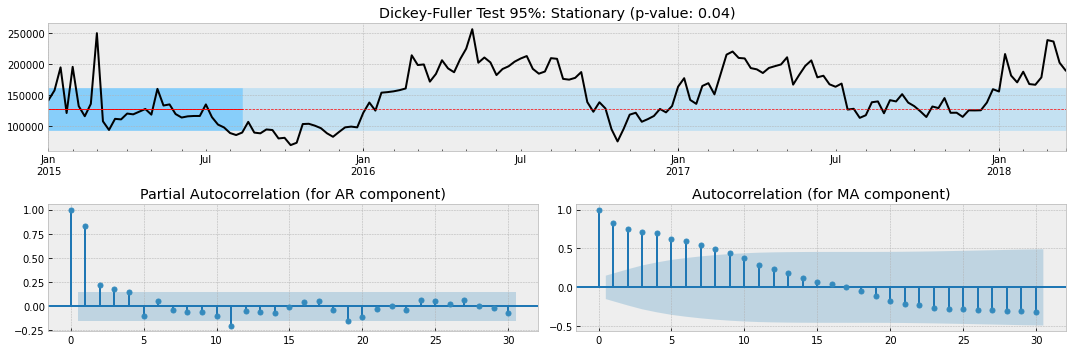

In [15]:
ser.test_stationarity_acf_pacf(data_processing, sample=0.20, maxlag=w, figsize=(15,5))

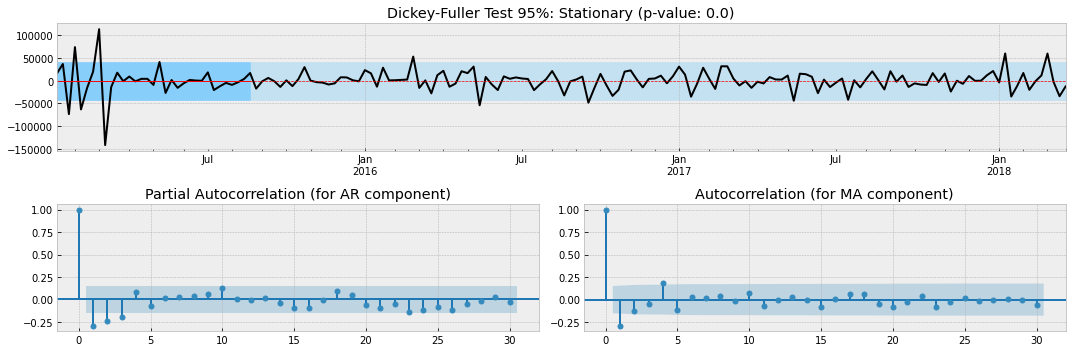

In [16]:
ser.test_stationarity_acf_pacf(ser.diff_ts(data_processing, order=1), sample=0.20, maxlag=30, figsize=(15,5))

#### 1.3.3.2. Seasonality

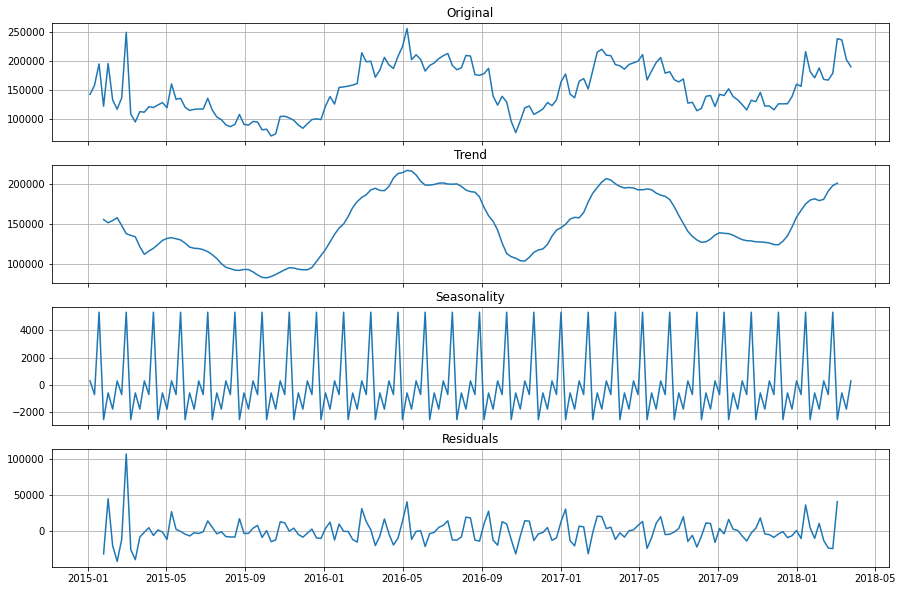

In [17]:
dic_decomposed = ser.decompose_ts(data_processing, s=6, figsize=(15,10))

In [18]:
#### -> Using weekly seasonality there are smaller residuals
s = 6

### 1.4. - Preprocessing

#### 1.4.1. Differenciating

#### 1.4.2. Partitioning

--- splitting at index:  138 | 2017-08-27 00:00:00 | test size: 0.18  ---


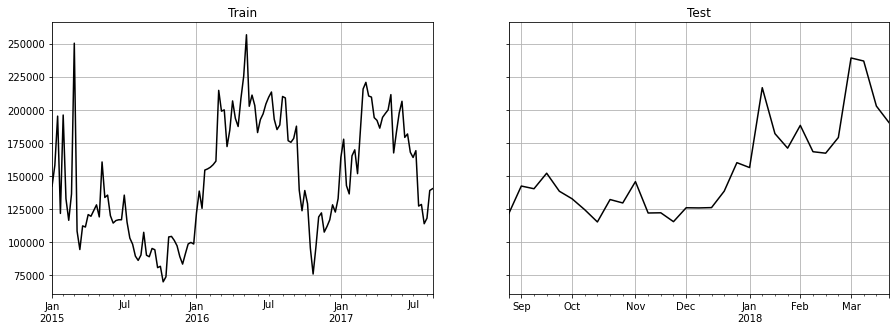

train: 138 obs  |  test: 31 obs


In [19]:
ts_train, ts_test = ser.split_train_test(data_processing, exog=None, test="2017-08-27", plot=True, figsize=(15,5))
print("train:", len(ts_train), "obs  |  test:", len(ts_test), "obs")

### 1.5 - Baseline (Random Walk)

#### 1.5.1. Train/Test

--- computing confidence interval ---


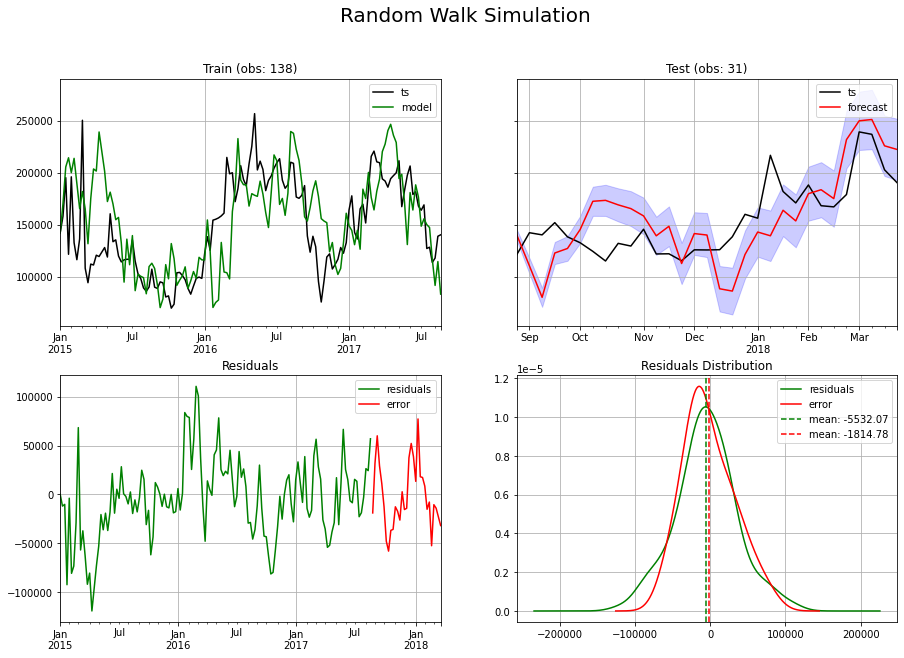

Training --> Residuals mean: -5532.0  | std: 40674.0
Test --> Error mean: -1815.0  | std: 33344.0  | mae: 27426.0  | mape: 19.0 %  | mse: 1079276845.0  | rmse: 32852.0


In [20]:
dtf = ser.simulate_rw(ts_train, ts_test, conf=0.10, figsize=(15,10))

#### 1.5.2. Forecast unknown

--- generating index date --> freq: W | start: 2018-04-01 00:00:00 | end: 2022-03-20 00:00:00 | len: 208 ---
--- computing confidence interval ---


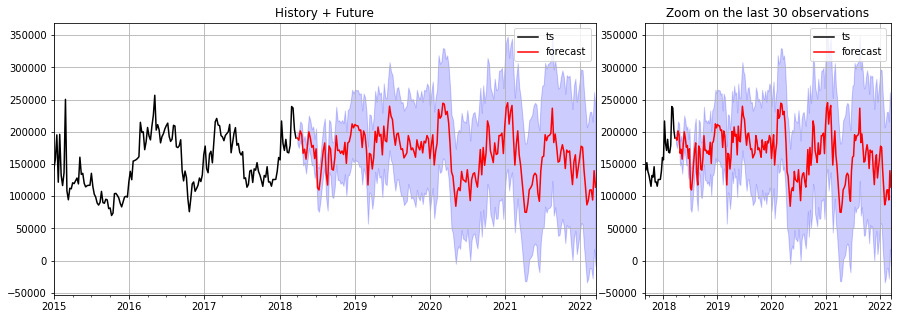

In [21]:
future = ser.forecast_rw(data_processing, end=end, conf=0.10, zoom=30, figsize=(15,5))

### 1.6. - Model Desing & Testing (Autoregressive)

#### 1.6.1 Exponential Smoothing

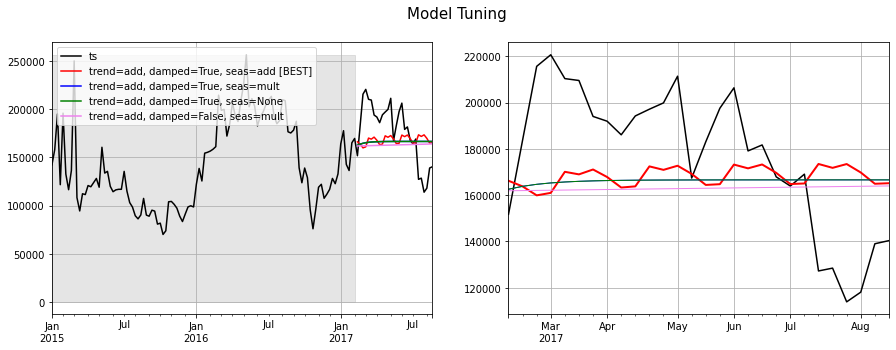

,combo,score,model
0,"trend=add, damped=True, seas=add",28005.67,<statsmodels.tsa.holtwinters.HoltWintersResult...
1,"trend=add, damped=True, seas=mult",28216.31,<statsmodels.tsa.holtwinters.HoltWintersResult...
2,"trend=add, damped=True, seas=None",28216.31,<statsmodels.tsa.holtwinters.HoltWintersResult...
3,"trend=add, damped=False, seas=mult",29974.50,<statsmodels.tsa.holtwinters.HoltWintersResult...
4,"trend=add, damped=False, seas=None",29974.50,<statsmodels.tsa.holtwinters.HoltWintersResult...


In [22]:
# Tuning
res = ser.tune_expsmooth_model(ts_train, s=s, val_size=0.2, scoring=reg.metrics.mean_absolute_error, top=4, figsize=(15,5))
res.head()

Seasonal parameters: multiplicative Seasonality every 6 observations
--- computing confidence interval ---


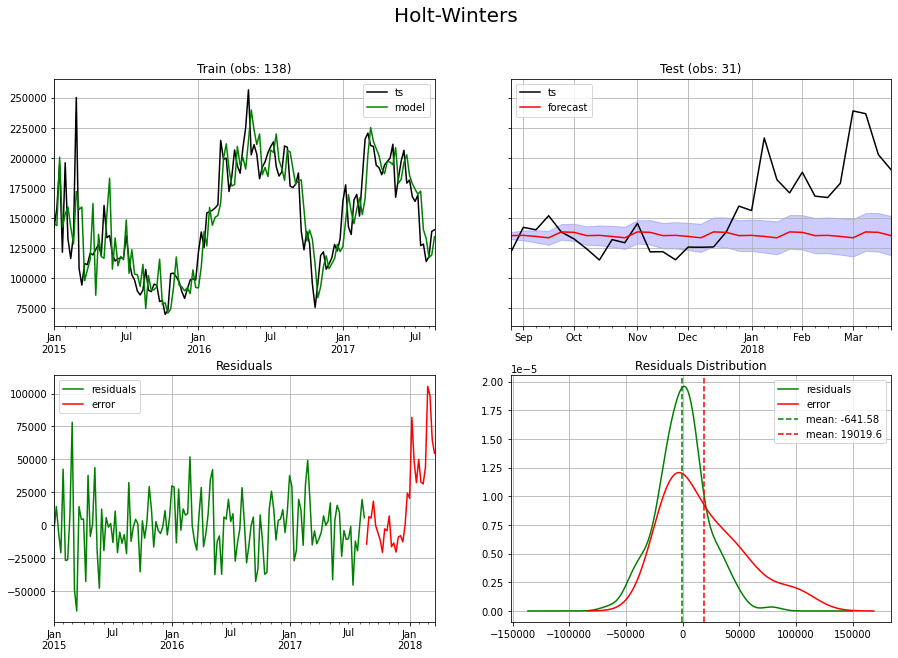

Training --> Residuals mean: -642.0  | std: 22508.0
Test --> Error mean: 19020.0  | std: 34992.0  | mae: 27872.0  | mape: 16.0 %  | mse: 1546701669.0  | rmse: 39328.0


In [23]:
# Train/Test
dtf, model = ser.fit_expsmooth(ts_train, ts_test, trend="additive", damped=False, seasonal="multiplicative", s=s,
                           factors=(None,None,None), conf=0.10, figsize=(15,10))

--- generating index date --> freq: W | start: 2018-04-01 00:00:00 | end: 2022-03-20 00:00:00 | len: 208 ---
--- computing confidence interval ---


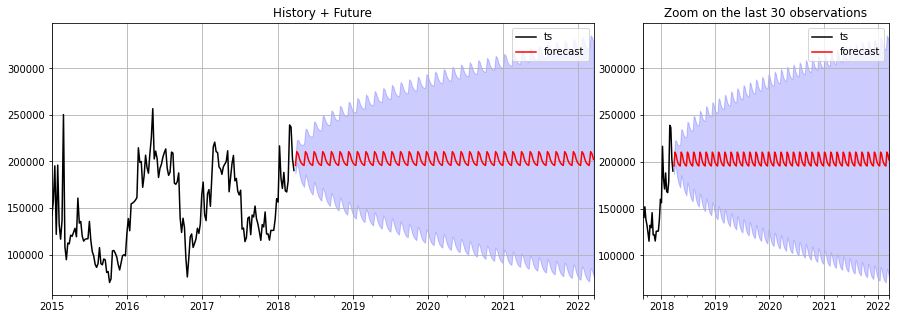

In [24]:
# Forecast unknown
model = ser.smt.ExponentialSmoothing(data_processing, trend="additive", damped=False, 
                                 seasonal="multiplicative", seasonal_periods=s).fit(0.64)

future = ser.forecast_autoregressive(data_processing, model, end=end, conf=0.30, zoom=30, figsize=(15,5))

#### 1.6.2. SarimaX

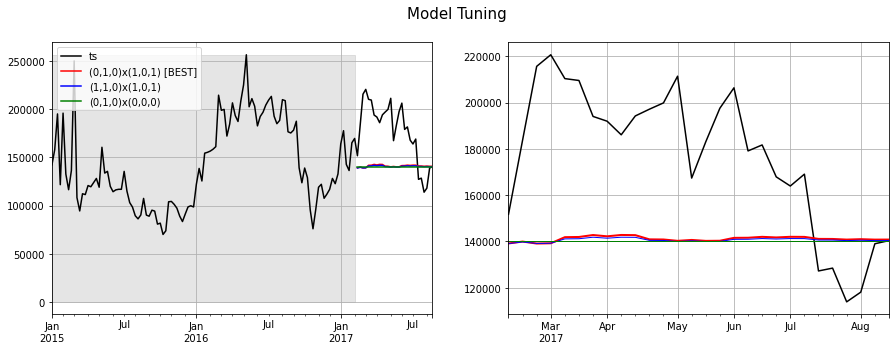

,combo,score,model
0,"(0,1,0)x(1,0,1)",41277.98,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
1,"(1,1,0)x(1,0,1)",41596.67,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
2,"(0,1,0)x(0,0,0)",41796.06,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
3,"(1,1,0)x(0,0,1)",41910.12,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
4,"(1,1,0)x(1,0,0)",41911.44,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...


In [25]:
# Tuning (this takes a while)
res = ser.tune_arima_model(ts_train, s=s, val_size=0.2, max_order=(1,1,1), seasonal_order=(1,0,1),
                        scoring=ser.metrics.mean_absolute_error, top=3, figsize=(15,5))
res.head()

In [26]:
# Tuning (this takes a while)
ser.find_best_sarimax(ts_train, seasonal=True, stationary=False, s=s, exog=None,
                  max_p=10, max_d=3, max_q=10, 
                  max_P=1, max_D=1, max_Q=1)

best model --> (p, d, q): (0, 1, 1)  and  (P, D, Q, s): (0, 0, 0, 6)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  138
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -1578.854
Date:                Mon, 22 Nov 2021   AIC                           3163.708
Time:                        21:56:37   BIC                           3172.468
Sample:                             0   HQIC                          3167.268
                                - 138                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -104.2979   1294.221     -0.081      0.936   -2640.924    2432.328
ma.L1         -0.3486      0.035     -9.867      0.000      -0.418      -0.279
sigma2      5.024e+08      0.021   2.44e+10      0.000    5.02e+08    5.02e+08
===================================================================================
Ljung-Box (Q):                       30.48   Jarque-Bera (JB):               149.94
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               0.35   Skew:                             0.37
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.84e+27. Standard errors may be unstable.
"""

Trend parameters: d=1
Seasonal parameters: Seasonality every 6 observations
Exog parameters: Not given


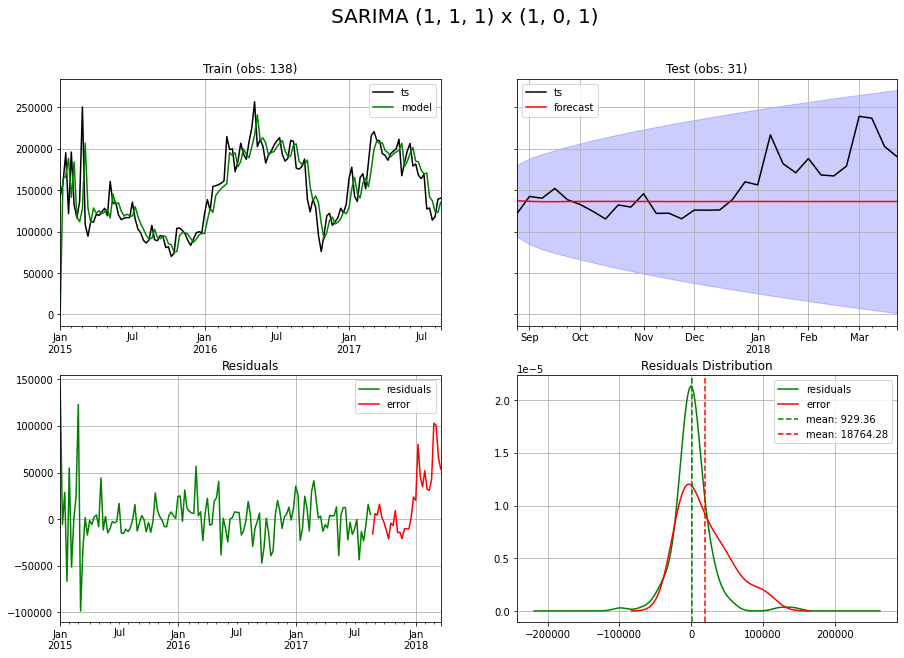

Training --> Residuals mean: 929.0  | std: 26578.0
Test --> Error mean: 18764.0  | std: 35009.0  | mae: 28040.0  | mape: 16.0 %  | mse: 1538193618.0  | rmse: 39220.0


In [27]:
# Train/Test
dtf, model = ser.fit_sarimax(ts_train, ts_test, order=(1,1,1), seasonal_order=(1,0,1), s=s, conf=0.95, figsize=(15,10))

--- generating index date --> freq: W | start: 2018-04-01 00:00:00 | end: 2022-03-20 00:00:00 | len: 208 ---


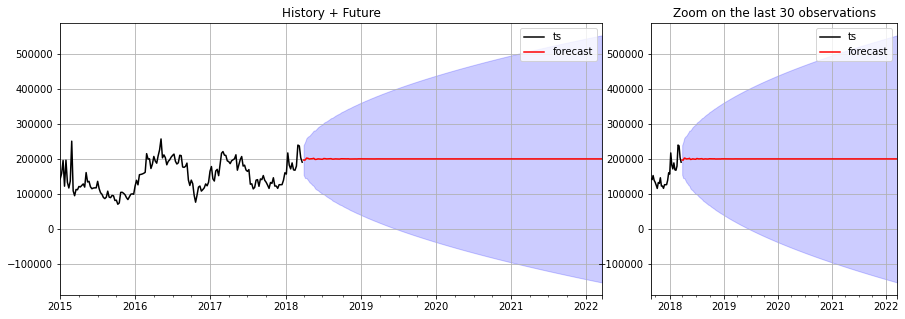

In [28]:
# Forecast unknown
model = ser.smt.SARIMAX(data_processing, order=(1,1,1), seasonal_order=(1,0,1,s), exog=None).fit()

future = ser.forecast_autoregressive(data_processing, model, end=end, conf=0.95, zoom=30, figsize=(15,5))

### 1.7. Model Desing & Testing (Neural Network)

#### 1.7.1. Train/test

In [29]:
# I will try to expand the memory to 1y, losing 365 days of training. This takes a while.
s = 136
n_features = 1

In [30]:
# Number of features is 1
model = ser.models.Sequential()
model.add( ser.layers.LSTM(input_shape=(s,n_features), units=50, activation='relu', return_sequences=True) )
model.add( ser.layers.Dropout(0.2) )
model.add( ser.layers.LSTM(units=50, activation='relu', return_sequences=False) )
model.add( ser.layers.Dense(1) )
model.compile(optimizer='adam', loss='mean_absolute_error')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 136, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 136, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


Seasonality: using the last 136 observations to predict the next 1
--- X: (2, 136, 1) | y: (2,) ---
--- computing confidence interval ---


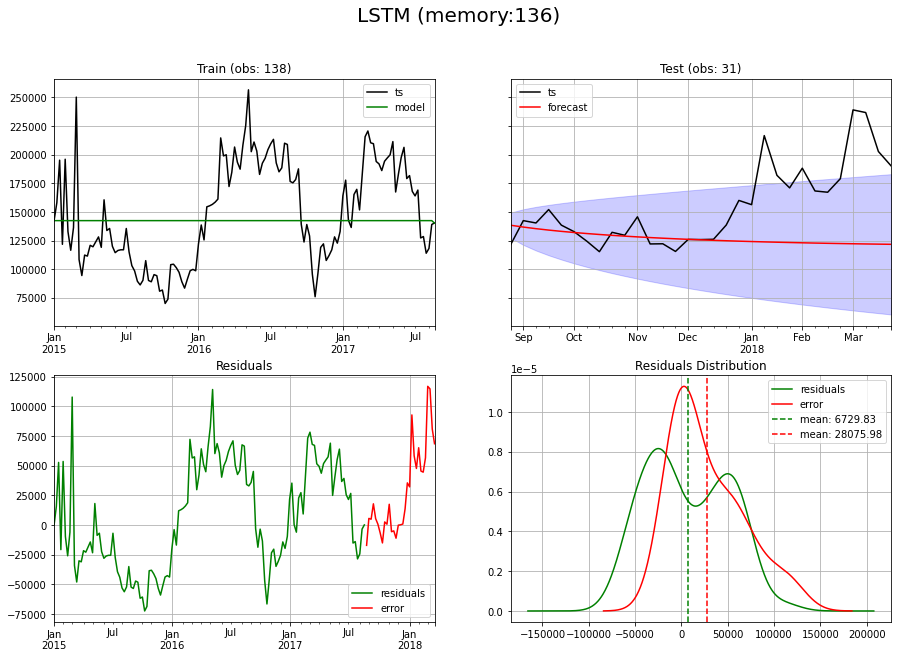

Training --> Residuals mean: 6730.0  | std: 44031.0
Test --> Error mean: 28076.0  | std: 38067.0  | mae: 31966.0  | mape: 17.0 %  | mse: 2190626256.0  | rmse: 46804.0


In [31]:
dtf, model = ser.fit_lstm(ts_train, ts_test, model, exog=None, s=s, epochs=100, conf=0.20, figsize=(15,10))

#### 1.7.2. Forecast unknown 

--- generating index date --> freq: W | start: 2018-04-01 00:00:00 | end: 2022-03-20 00:00:00 | len: 208 ---
--- computing confidence interval ---


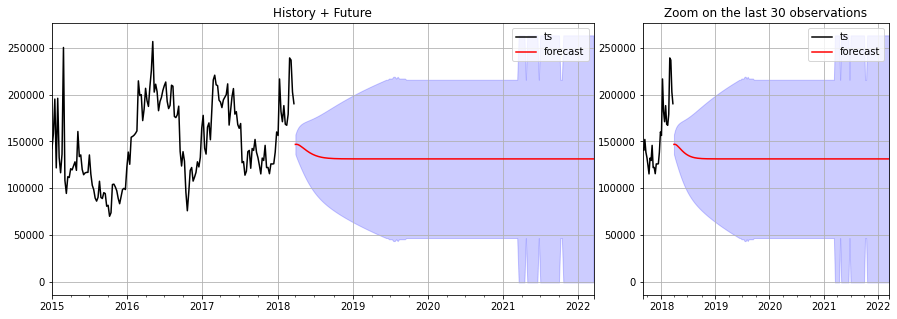

In [32]:
future = ser.forecast_lstm(data_processing, model, conf=0.20, end=end, zoom=30, figsize=(15,5))

### 1.8. Model Desing & Testing (Prophet)

#### 1.8.1. Train / Evaluate

In [33]:
# Create dataframe with columns 'ds' (dates), 'y' (values), 'cap' (capacity if growth="logistic"), 
# other additional regressor
dtf_train = ts_train.reset_index().rename(columns={"fea_date":"ds", "fea_total_Volume":"y"})
dtf_test = ts_test.reset_index().rename(columns={"fea_date":"ds", "fea_total_Volume":"y"})

dtf_train.tail()

,ds,y
133,2017-07-23,128480.81
134,2017-07-30,113903.29
135,2017-08-06,118098.82
136,2017-08-13,139016.53
137,2017-08-20,140365.99


In [34]:
# Create Holidays dataFrame with columns 'ds' (dates) and 'holiday' (string ex 'xmas')
dtf_holidays = None

In [35]:
model = ser.Prophet(growth="linear", changepoints=None, n_changepoints=25, seasonality_mode="multiplicative",
                yearly_seasonality="auto", weekly_seasonality="auto", daily_seasonality=False,
                holidays=dtf_holidays, interval_width=0.80)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


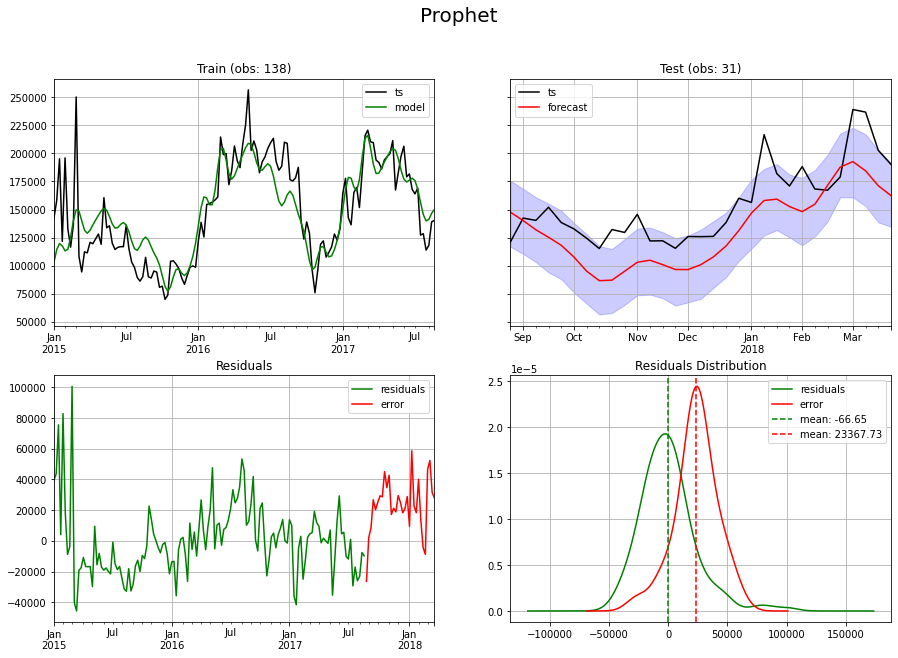

Training --> Residuals mean: -67.0  | std: 23217.0
Test --> Error mean: 23368.0  | std: 17754.0  | mae: 25909.0  | mape: 17.0 %  | mse: 851073766.0  | rmse: 29173.0


In [36]:
dtf, model = ser.fit_prophet(dtf_train, dtf_test, model=model, figsize=(15,10))

#### 1.8.2. Forecast unknown 

In [37]:
dtf = data_processing.reset_index().rename(columns={"fea_date":"ds", "fea_total_Volume":"y"})
dtf.tail()

,ds,y
164,2018-02-25,179041.72
165,2018-03-04,239135.67
166,2018-03-11,236822.98
167,2018-03-18,202790.74
168,2018-03-25,190257.38


In [38]:
model = ser.Prophet(growth="linear", changepoints=None, n_changepoints=25, seasonality_mode="multiplicative",
                yearly_seasonality="auto", weekly_seasonality="auto", daily_seasonality=False,
                holidays=dtf_holidays, interval_width=0.80)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


--- generating index date --> freq: W | start: 2018-04-01 00:00:00 | end: 2022-03-20 00:00:00 | len: 208 ---


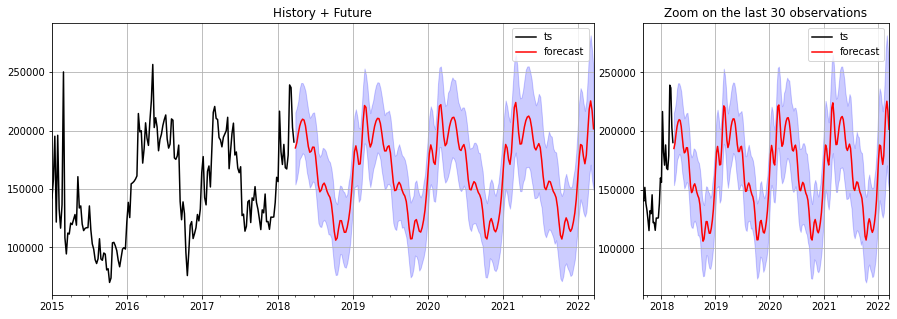

In [39]:
future = ser.forecast_prophet(dtf, model, end=end, zoom=30, figsize=(15,5))

### Nhận xét:
- Giá sẽ có xu hướng tăng qua các năm đối với loại bơ tăng qua các năm ở vùng california
- Sản lượng thì lại không có xu hướng tăng
=> Cho nên trong 5 năm tới có xu hương không tăng cho nên không cần mở rộng sản xuất bơ truyền thống

### 1.9 - Model Desing & Testing (Custom Model)

#### 1.9.1. Train / Evaluate

--- generating index date --> freq: W | start: 2017-02-12 00:00:00 | end: 2017-08-13 00:00:00 | len: 27 ---


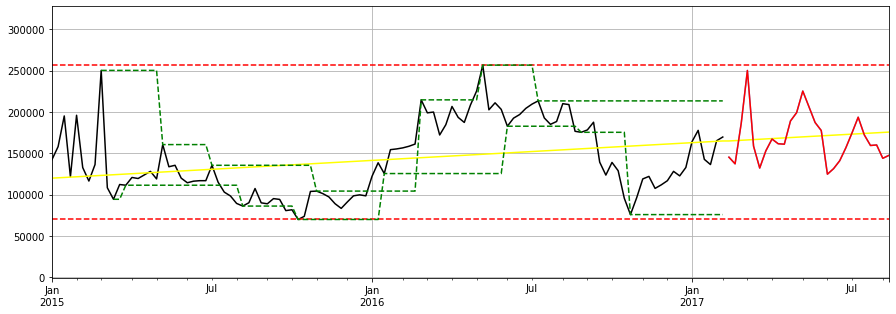

In [40]:
# Tuning
tune = ser.custom_model(ts_train.head(int(0.8*len(ts_train))), pred_ahead=int(0.2*len(ts_train)), 
                    trend=True, seasonality_types=["woy","moy"], 
                    level_window=7, sup_res_windows=(365,365), floor_cap=(True,True), 
                    plot=True, figsize=(15,5))

In [41]:
trend = True
seasonality_types = ["woy","moy"]
level_window = 7
sup_res_windows = (365,365)
floor_cap = (True,True)

--- generating index date --> freq: W | start: 2017-08-27 00:00:00 | end: 2018-03-25 00:00:00 | len: 31 ---
--- computing confidence interval ---


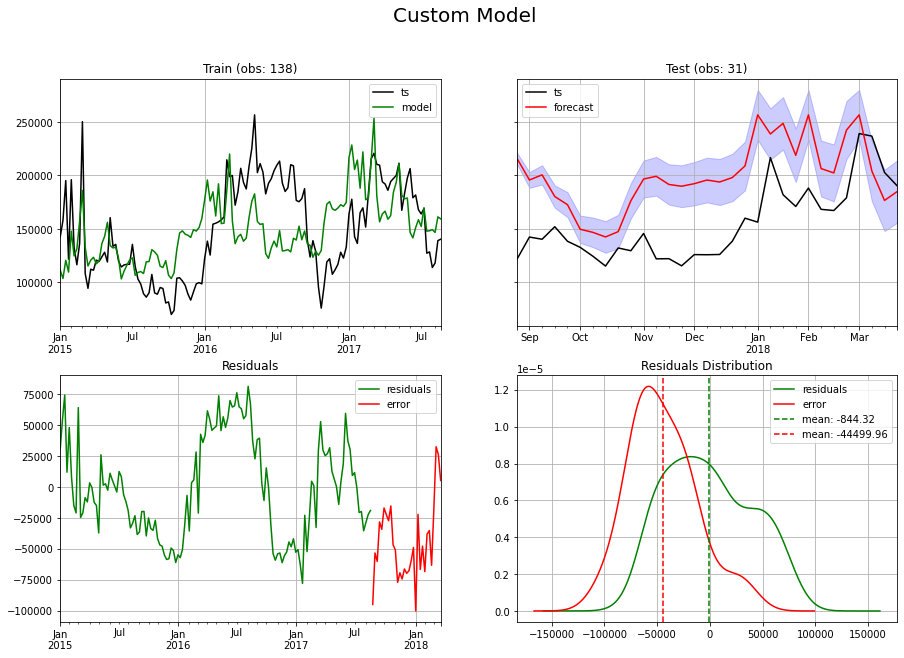

Training --> Residuals mean: -844.0  | std: 40248.0
Test --> Error mean: -44500.0  | std: 31373.0  | mae: 48634.0  | mape: 34.0 %  | mse: 2932769163.0  | rmse: 54155.0


In [42]:
dtf = ser.fit_custom_model(ts_train, ts_test, trend, seasonality_types, level_window, sup_res_windows, floor_cap,
                       conf=0.1, figsize=(15,10))

#### 1.9.2. Forecast unknown 

--- generating index date --> freq: W | start: 2018-04-01 00:00:00 | end: 2022-03-20 00:00:00 | len: 208 ---
--- generating index date --> freq: W | start: 2018-04-01 00:00:00 | end: 2022-03-20 00:00:00 | len: 208 ---
--- computing confidence interval ---


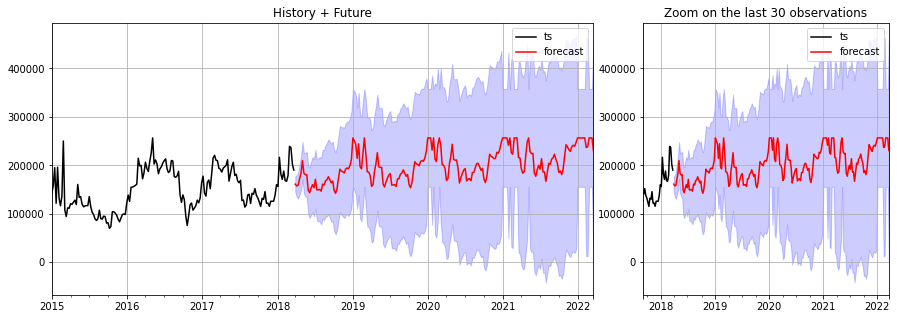

In [43]:
future = ser.forecast_custom_model(data_processing, trend, seasonality_types, level_window, sup_res_windows, floor_cap,
                               conf=0.3, end=end, zoom=30, figsize=(15,5))